In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import stochnewton

from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_classification

In [18]:
np.random.seed(42)

In [184]:
import imp
imp.reload(stochnewton)

<module 'stochnewton' from 'C:\\Users\\Denis\\pythonProject\\Jupyter_Main\\Учеба\\6_семестр\\Статья\\Baseline algorithm\\stochnewton.py'>

$f_i(x) = \log(1 + \exp(-b_i \cdot a_i^T x)) + \frac{\lambda}{2}\|x\|_2^2,\quad b_i = \pm 1$

Константа Липшица для градиентов $L_i = \frac{1}{4} \|a_i\|^2$, для Гессианов $H_i = \frac{1}{10} \|a_i\|^3$. Для начала отнормируем данные по строкам и посмотрим, как работют алгоритмы

In [181]:
n_samples, n_features = 500, 5
A, b = make_classification(n_samples=n_samples,
                    n_features=n_features,
                    n_informative=5,
                    n_redundant=0,
                    n_repeated=0,
                    random_state=42)
A = A / np.linalg.norm(A, axis=1)[:, None]
b = b * 2 - 1

Построим график зависимости $W = \frac{1}{n} \sum \limits_{i=1}^n \|w_i - x^*\|^2$ от числа проходов по данным для стратегии $\tau$-nice, $\tau = 1$

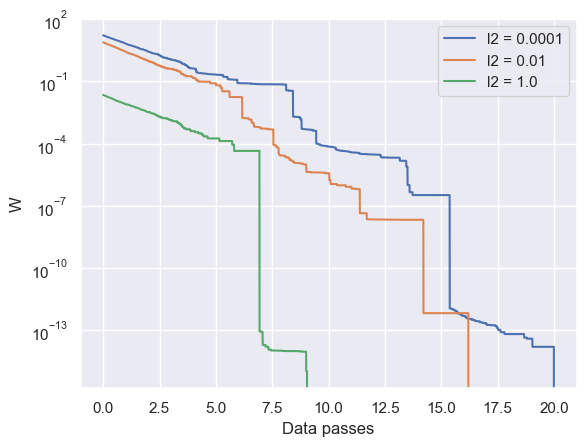

In [6]:
l2_grid = [1e-4, 1e-2, 1e-0]

n_epochs = 20
n_iterations = n_epochs * n_samples
batch_size = 1

for l2 in l2_grid:
    det_newton = stochnewton.DeterministicNewtonLogReg(A, b, l2=l2)
    det_newton.run(n_iterations=20, plot_loss=False)
    opt_value = det_newton.calculate_loss()
    opt_x = det_newton.x
    
    stoch_newton = stochnewton.StochasticNewtonLogReg(A, b, l2=l2, opt_value=opt_value, opt_x=opt_x)
    stoch_newton.run(n_iterations=n_iterations, batch_size=batch_size, strategy='nice', plot_loss=False)
    
    plt.plot(np.linspace(0, n_epochs, n_iterations+1),
             stoch_newton.dist_history, label=f'l2 = {l2}')
    plt.xlabel('Data passes')
    plt.ylabel('W')
    plt.yscale('log')
    plt.legend()

Убедимся, что для нормированных данных $\tau$-nice и ИС имеют одинаковую скорость сходимости

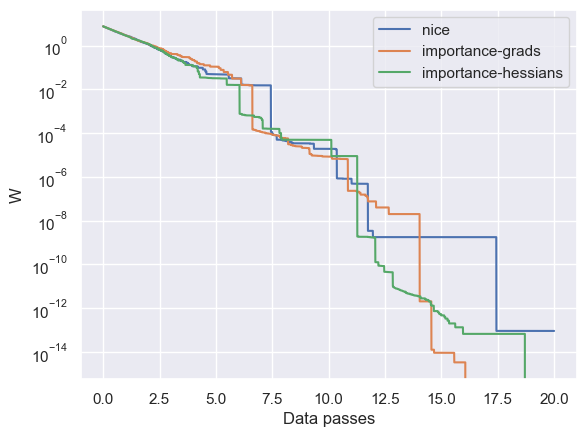

In [186]:
n_epochs = 20
n_iterations = n_epochs * n_samples
batch_size = 1
l2 = 1e-2

det = stochnewton.DeterministicNewtonLogReg(A, b, l2=l2)
det.run(n_iterations=20, plot_loss=False)
opt_value = det.calculate_loss()
opt_x = det.x

nice = stochnewton.StochasticNewtonLogReg(A, b, l2=l2, opt_value=opt_value, opt_x=opt_x)
nice.run(n_iterations=n_iterations, batch_size=batch_size, strategy='nice', plot_loss=False)

grad = stochnewton.StochasticNewtonLogReg(A, b, l2=l2, opt_value=opt_value, opt_x=opt_x)
grad.run(n_iterations=n_iterations, batch_size=batch_size, strategy='imp-grad', plot_loss=False)

hess = stochnewton.StochasticNewtonLogReg(A, b, l2=l2, opt_value=opt_value, opt_x=opt_x)
hess.run(n_iterations=n_iterations, batch_size=batch_size, strategy='imp-hess', plot_loss=False)

plt.plot(np.linspace(0, n_epochs, n_iterations+1),
         nice.dist_history, label=f'nice')
plt.plot(np.linspace(0, n_epochs, n_iterations+1),
         grad.dist_history, label=f'importance-grads')
plt.plot(np.linspace(0, n_epochs, n_iterations+1),
         hess.dist_history, label=f'importance-hessians')

plt.xlabel('Data passes')
plt.ylabel('W')
plt.yscale('log')
plt.legend()
pass

Эффект от ИС может быть только, если у нас есть неравномерное распределение констант Липшица

## Ненормированные данные

In [187]:
n_samples, n_features = 500, 5
A, b = make_classification(n_samples=n_samples,
                    n_features=n_features,
                    n_informative=5,
                    n_redundant=0,
                    n_repeated=0,
                    random_state=42)
b = b * 2 - 1

Сравним $\tau$-nice и ИС

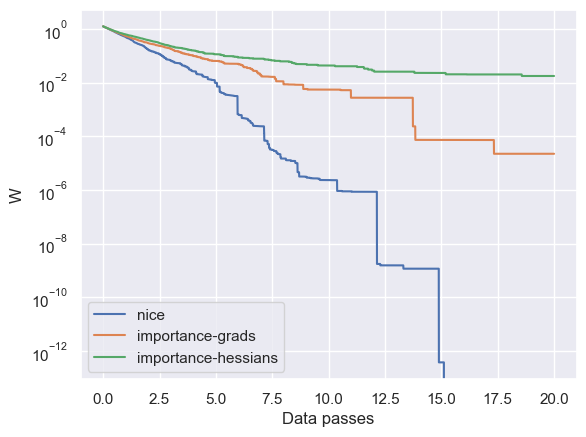

In [188]:
n_epochs = 20
n_iterations = n_epochs * n_samples
batch_size = 1
l2 = 1e-2

det = stochnewton.DeterministicNewtonLogReg(A, b, l2=l2)
det.run(n_iterations=20, plot_loss=False)
opt_value = det.calculate_loss()
opt_x = det.x

nice = stochnewton.StochasticNewtonLogReg(A, b, l2=l2, opt_value=opt_value, opt_x=opt_x)
nice.run(n_iterations=n_iterations, batch_size=batch_size, strategy='nice', plot_loss=False)

grad = stochnewton.StochasticNewtonLogReg(A, b, l2=l2, opt_value=opt_value, opt_x=opt_x)
grad.run(n_iterations=n_iterations, batch_size=batch_size, strategy='imp-grad', plot_loss=False)

hess = stochnewton.StochasticNewtonLogReg(A, b, l2=l2, opt_value=opt_value, opt_x=opt_x)
hess.run(n_iterations=n_iterations, batch_size=batch_size, strategy='imp-hess', plot_loss=False)

plt.plot(np.linspace(0, n_epochs, n_iterations+1),
         nice.dist_history, label=f'nice')
plt.plot(np.linspace(0, n_epochs, n_iterations+1),
         grad.dist_history, label=f'importance-grads')
plt.plot(np.linspace(0, n_epochs, n_iterations+1),
         hess.dist_history, label=f'importance-hessians')

plt.xlabel('Data passes')
plt.ylabel('W')
plt.yscale('log')
plt.legend()
pass

Мы видим, что ИС проигрывает $\tau$-nice

На самом деле у нас распределение констант Липшица очень уж неравномерное

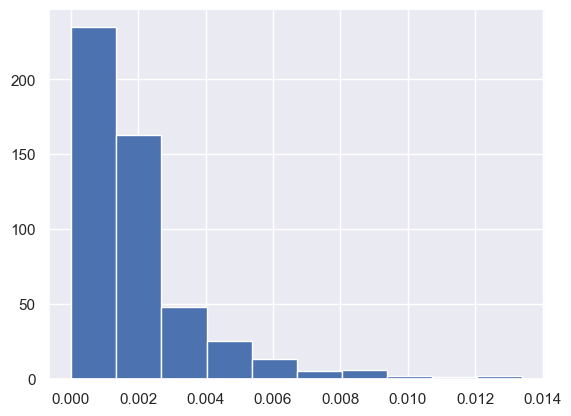

In [191]:
p = hess.hessians_lipschitzness / np.sum(hess.hessians_lipschitzness)
plt.hist(p)
pass

In [192]:
p.max() / p.min()

925.6908164165445

Возможно, если распределение констант Липшица будет ближе к нормальному, удастся обнаружить какой-то эффект

## Нормализованное распределение констант Липшица

In [199]:
n_samples, n_features = 500, 5
A, b = make_classification(n_samples=n_samples,
                    n_features=n_features,
                    n_informative=5,
                    n_redundant=0,
                    n_repeated=0,
                    random_state=42)
coefs = np.array([*map(lambda x: np.linalg.norm(x)**(2/3), A)])[:, None]
A /= coefs
b = b * 2 - 1

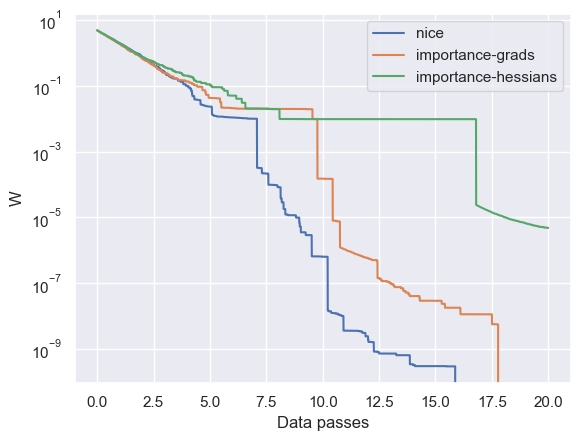

In [194]:
n_epochs = 20
n_iterations = n_epochs * n_samples
batch_size = 1
l2 = 1e-2

det = stochnewton.DeterministicNewtonLogReg(A, b, l2=l2)
det.run(n_iterations=20, plot_loss=False)
opt_value = det.calculate_loss()
opt_x = det.x

nice = stochnewton.StochasticNewtonLogReg(A, b, l2=l2, opt_value=opt_value, opt_x=opt_x)
nice.run(n_iterations=n_iterations, batch_size=batch_size, strategy='nice', plot_loss=False)

grad = stochnewton.StochasticNewtonLogReg(A, b, l2=l2, opt_value=opt_value, opt_x=opt_x)
grad.run(n_iterations=n_iterations, batch_size=batch_size, strategy='imp-grad', plot_loss=False)

hess = stochnewton.StochasticNewtonLogReg(A, b, l2=l2, opt_value=opt_value, opt_x=opt_x)
hess.run(n_iterations=n_iterations, batch_size=batch_size, strategy='imp-hess', plot_loss=False)

plt.plot(np.linspace(0, n_epochs, n_iterations+1),
         nice.dist_history, label=f'nice')
plt.plot(np.linspace(0, n_epochs, n_iterations+1),
         grad.dist_history, label=f'importance-grads')
plt.plot(np.linspace(0, n_epochs, n_iterations+1),
         hess.dist_history, label=f'importance-hessians')

plt.xlabel('Data passes')
plt.ylabel('W')
plt.yscale('log')
plt.legend()
pass

Распределение констант Липшица

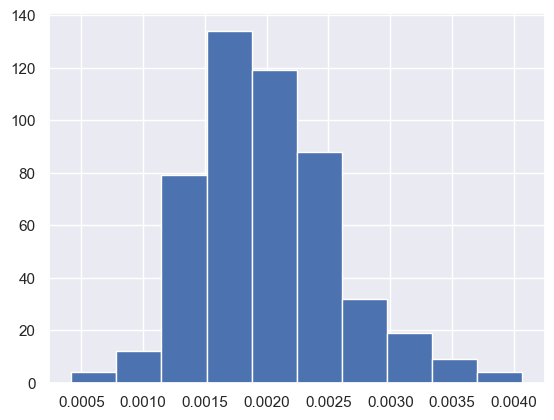

In [195]:
p = hess.hessians_lipschitzness / np.sum(hess.hessians_lipschitzness)
plt.hist(p)
pass

Таким образом, положительного эффекта в сходимости по аргументу не обнаружено. Можно попробовать рассмотреть сходимость по функции

## Сходимость по функции

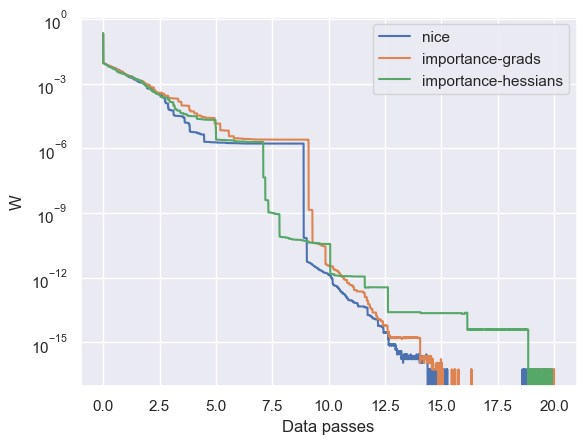

In [203]:
n_epochs = 20
n_iterations = n_epochs * n_samples
batch_size = 1
l2 = 1e-2

det = stochnewton.DeterministicNewtonLogReg(A, b, l2=l2)
det.run(n_iterations=20, plot_loss=False)
opt_value = det.calculate_loss()
opt_x = det.x

nice = stochnewton.StochasticNewtonLogReg(A, b, l2=l2, opt_value=opt_value, opt_x=opt_x)
nice.run(n_iterations=n_iterations, batch_size=batch_size, strategy='nice', plot_loss=False)

grad = stochnewton.StochasticNewtonLogReg(A, b, l2=l2, opt_value=opt_value, opt_x=opt_x)
grad.run(n_iterations=n_iterations, batch_size=batch_size, strategy='imp-grad', plot_loss=False)

hess = stochnewton.StochasticNewtonLogReg(A, b, l2=l2, opt_value=opt_value, opt_x=opt_x)
hess.run(n_iterations=n_iterations, batch_size=batch_size, strategy='imp-hess', plot_loss=False)

plt.plot(np.linspace(0, n_epochs, n_iterations+1),
         np.array(nice.loss_history) - opt_value, label=f'nice')
plt.plot(np.linspace(0, n_epochs, n_iterations+1),
         np.array(grad.loss_history) - opt_value, label=f'importance-grads')
plt.plot(np.linspace(0, n_epochs, n_iterations+1),
         np.array(hess.loss_history) - opt_value, label=f'importance-hessians')

plt.xlabel('Data passes')
plt.ylabel('W')
plt.yscale('log')
plt.legend()
pass

Как видно, выигрыша никакого нет